# Gradient Comparison for N-body Solvers

This notebook compares gradient computation across different solver/adjoint configurations:

1. **JAXPM ReversibleSolver** with diffrax `diffeqsolve` + checkpointed adjoint
2. **fwd_model_tools `integrate()`** with `EfficientDriftDoubleKick` + `adjoint='checkpointed'`
3. **fwd_model_tools `integrate()`** with `ReversibleDoubleKickDrift` + `adjoint='checkpointed'`
4. **fwd_model_tools `integrate()`** with `ReversibleDoubleKickDrift` + `adjoint='reverse'`
5. **fwd_model_tools legacy** with `ReversibleBaseSolver` + custom reverse adjoint

All configurations use `NoCorrection` and `NoInterp` for a clean comparison of the integration schemes.

## 1. Environment Setup

Configure JAX memory allocation and import required libraries.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
from functools import partial

# JAXPM imports
from jaxpm.pm import linear_field, lpt as jpm_lpt
from jaxpm.kernels import interpolate_power_spectrum
from jaxpm.ode import symplectic_ode
from diffrax import ConstantStepSize, ODETerm, SaveAt, diffeqsolve, SemiImplicitEuler
from diffrax import RecursiveCheckpointAdjoint

# fwd_model_tools imports
from fwd_model_tools import (
    Planck18,
    NoCorrection,
    NoInterp,
    EfficientDriftDoubleKick,
    ReversibleDoubleKickDrift,
    ParticleField,
    DensityField,
    PositionUnit,
    DensityUnit,
    distances,
    compute_lightcone_shells,
    lpt,
    gaussian_initial_conditions,
)
from fwd_model_tools.pm import integrate
from fwd_model_tools.fields.painting import PaintingOptions

# Legacy diffrax-based integration (optional dependency)
from fwd_model_tools.pm.legacy import (
    integrate as legacy_integrate,
    ReversibleBaseSolver,
    symplectic_fpm,
)

jax.config.update("jax_enable_x64", True)

/lustre/fswork/projects/rech/tkc/commun/venv/a100/lib/python3.11/site-packages/jax/_src/compiler.py:783: UserWarning: Error reading persistent compilation cache entry for 'jit_convert_element_type': PermissionError: [Errno 13] Permission denied: '/jax_cache'
  warnings.warn(


## 2. Configuration

Define simulation parameters. We use a small mesh for faster gradient testing.

In [2]:
# Small config for gradient testing
resolution = 128
mesh_size = (resolution, ) *3
box_size = (500.0, 500.0, 500.0)
t0, t1 = 0.1, 1.0
dt0 = 0.05
seed = 42
nb_shells = 4
nside = resolution
field_size = (10. , 10.)
flatsky_npix =(resolution, ) *2
cosmo = Planck18()

print(f"Mesh size: {mesh_size}")
print(f"Box size: {box_size} Mpc/h")
print(f"Scale factor range: [{t0}, {t1}]")
print(f"Time step: {dt0}")

Mesh size: (128, 128, 128)
Box size: (500.0, 500.0, 500.0) Mpc/h
Scale factor range: [0.1, 1.0]
Time step: 0.05


## 3. Initial Conditions (Shared)

Generate initial conditions using JAXPM's `linear_field` and `lpt` functions. These will be shared across all solver configurations.

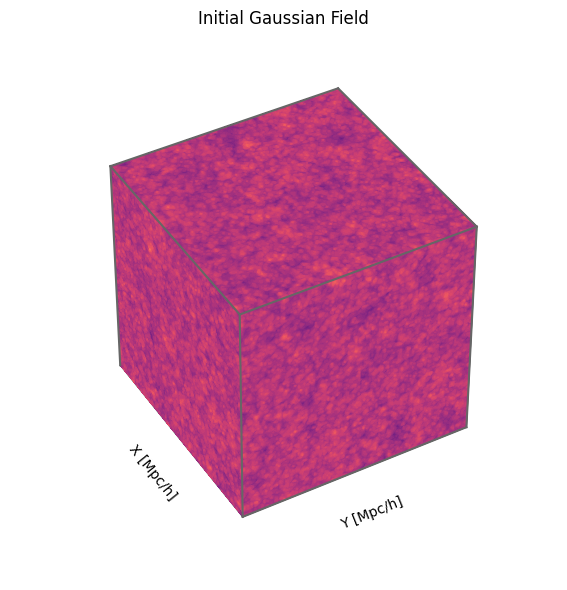

In [3]:
# JAXPM-style initial conditions
# 1) Gaussian initial field (pk_fn left None to use default)
key = jax.random.PRNGKey(0)
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo, nside=nside, flatsky_npix=flatsky_npix, field_size=field_size
)
initial_field.show(labels=["X [Mpc/h]", "Y [Mpc/h]", ""] , colorbar=False , titles=["Initial Gaussian Field"])

## 5. JAXPM with diffrax diffeqsolve (Checkpointed)

Run JAXPM simulation using diffrax's `diffeqsolve` with `RecursiveCheckpointAdjoint` for memory-efficient gradient computation.

In [46]:
def run_jaxpm_diffrax_checkpointed(initial_conditions, cosmo, t0, t1, dt0):
    """JAXPM simulation with diffrax and checkpointed adjoint."""
    # Get LPT initial conditions
    dx, p, _ = jpm_lpt(
        cosmo, initial_conditions, particles=None, a=t0, order=1,
        sharding=None, halo_size=0
    )
    
    drift, kick = symplectic_ode(
        mesh_size, cosmo, paint_absolute_pos=False,
        halo_size=0, sharding=None
    )
    ode_fn = ODETerm(kick), ODETerm(drift)
    solver = SemiImplicitEuler()

    y0 = (p, dx)
    r_center , ts = compute_lightcone_shells(cosmo , initial_field, nb_shells=nb_shells)
    saveat = SaveAt(ts=ts)

    res = diffeqsolve(
        ode_fn, solver,
        t0=t0, t1=t1, dt0=dt0,
        y0=y0, args=cosmo,
        saveat=saveat,
        stepsize_controller=ConstantStepSize(),
        adjoint=RecursiveCheckpointAdjoint(checkpoints=10),
    )
    return res.ys[1]

In [47]:


# Test forward pass
print("Running JAXPM forward pass...")
final_dx_jaxpm = run_jaxpm_diffrax_checkpointed(initial_field.array, cosmo, t0, t1, dt0)
jpm_particles = ParticleField.FromDensityMetadata(
    array=final_dx_jaxpm,
    field=initial_field,
    unit=PositionUnit.GRID_RELATIVE,
)
print(f"Final displacement norm: {jnp.linalg.norm(final_dx_jaxpm):.6f}")

# Test gradient
def loss_jaxpm(ic , observed):
    dx_final = run_jaxpm_diffrax_checkpointed(ic, cosmo, t0, t1, dt0)
    return jnp.sum((dx_final - observed) **2)

print("Computing JAXPM gradient...")
grad_jaxpm = jax.grad(loss_jaxpm)(initial_field.array, final_dx_jaxpm)
print(f"Gradient norm: {jnp.linalg.norm(grad_jaxpm)}")

Running JAXPM forward pass...
Final displacement norm: 9819.348394
Computing JAXPM gradient...
Gradient norm: 2.2026673100850803e-10


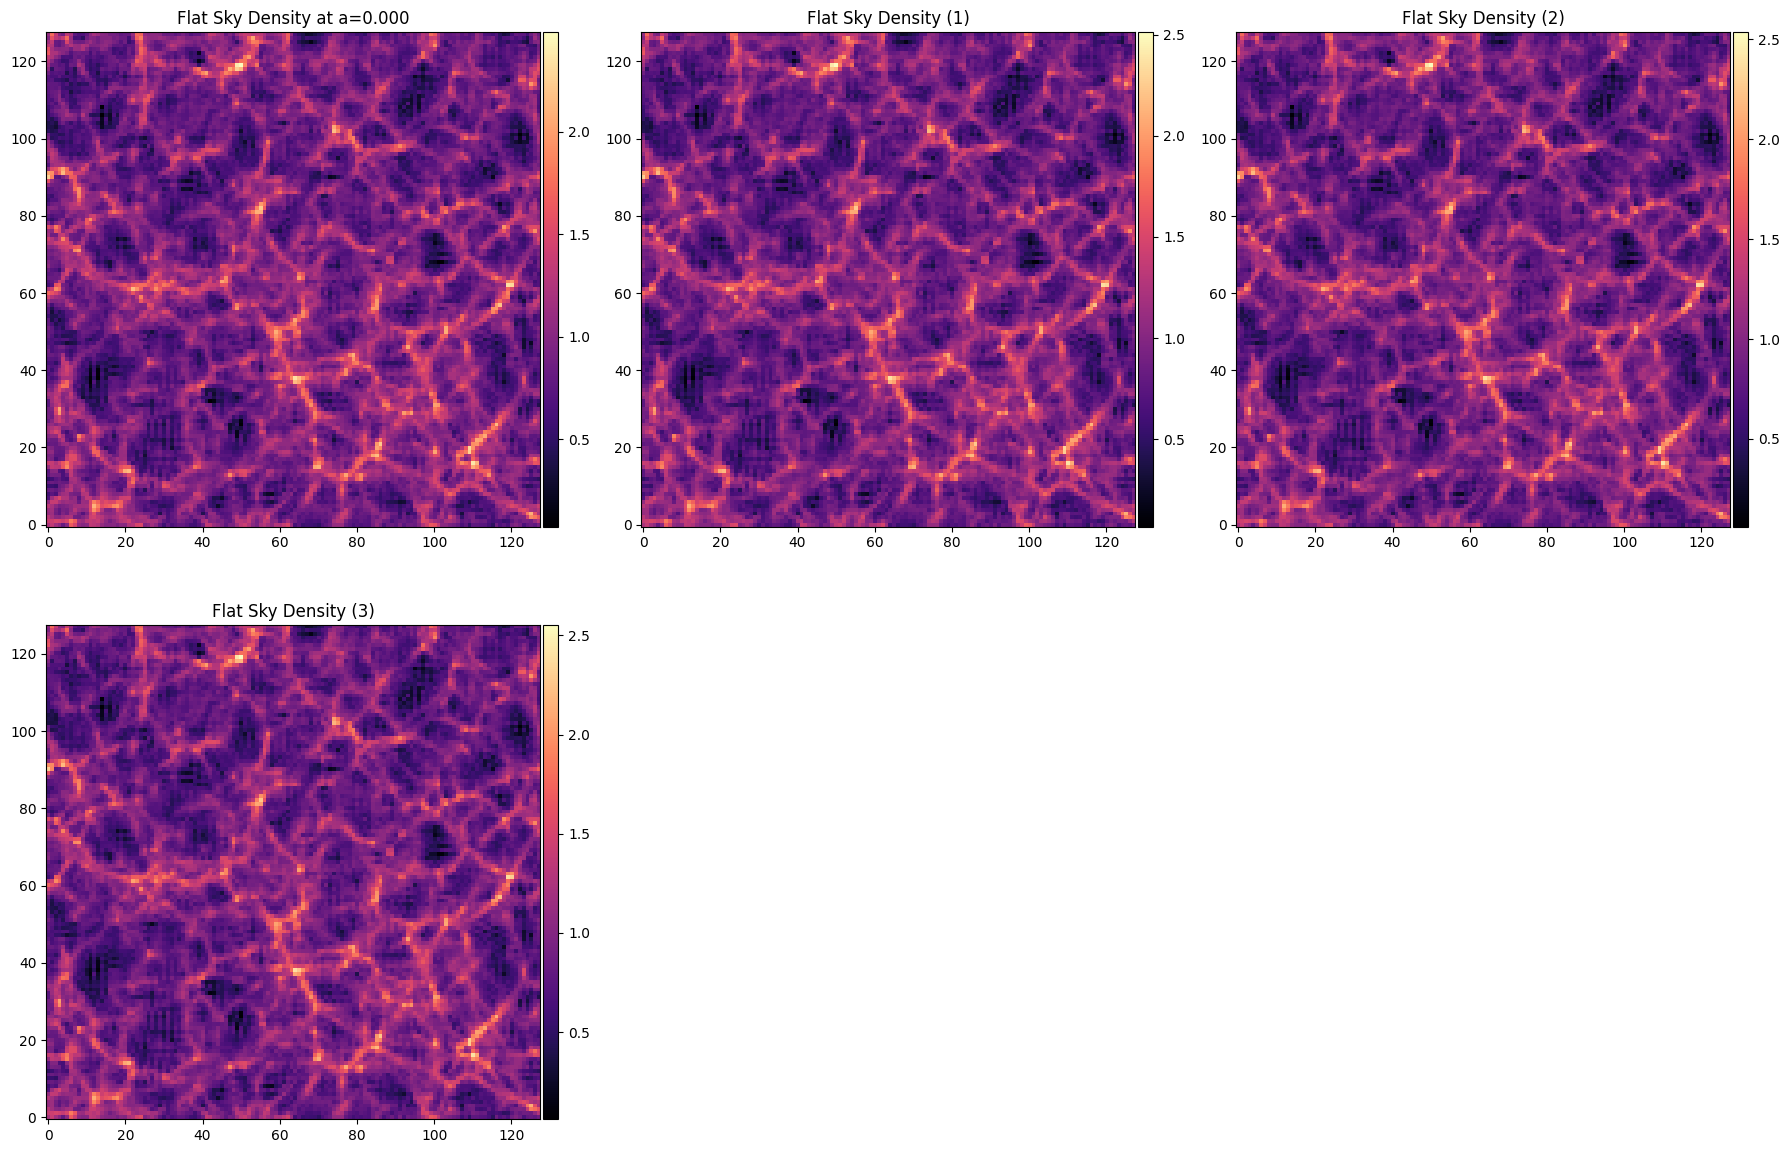

In [48]:
jpm_particles.paint().project().show(apply_log=True)

## 6. EfficientDriftDoubleKick (DKK) with Checkpointed Adjoint

Run the `EfficientDriftDoubleKick` solver (FastPM-style KDK scheme) with checkpointed adjoint.

In [51]:
# Create DKK solver

r_center , ts = compute_lightcone_shells(cosmo , initial_field, nb_shells=nb_shells)
widths = distances(r_center)
interp_kernel = NoInterp(painting=PaintingOptions(target="particles") , r_centers=r_center , ts=ts , density_widths=widths , max_comoving_distance=initial_field.max_comoving_radius)

solver_dkk = EfficientDriftDoubleKick(
    pgd_kernel=NoCorrection(),
    interp_kernel=interp_kernel,
)

def run_dkk_checkpointed(initial_conditions, cosmo, t0, t1, dt0):
    """Run DKK solver with checkpointed adjoint."""
    # Get LPT initial conditions from JAXPM
    dx, p = lpt(
        cosmo, initial_conditions,  scale_factor_spec=t0, order=1,
        painting=PaintingOptions(target="particles")
    )

    snapshots = integrate(
        displacements=dx,
        velocities=p,
        cosmo=cosmo,
        ts=ts,
        solver=solver_dkk,
        t0=t0, t1=t1, dt0=dt0,
        adjoint='checkpointed'
    )
    return snapshots

# Test forward pass
print("Running DKK forward pass...")
final_dx_dkk = run_dkk_checkpointed(initial_field, cosmo, t0, t1, dt0)
print(f"Final displacement norm: {jnp.linalg.norm(final_dx_dkk):.6f}")

# Test gradient
def loss_dkk(ic , observed):
    dx_final = run_dkk_checkpointed(ic, cosmo, t0, t1, dt0)
    return jnp.sum(jnp.pow(dx_final - observed, 2))

print("Computing DKK gradient...")
grad_dkk = jax.grad(loss_dkk)(initial_field , final_dx_dkk)
print(f"Gradient norm: {jnp.linalg.norm(grad_dkk):.6f}")

Running DKK forward pass...
Final displacement norm: 269217.826661
Computing DKK gradient...
Gradient norm: 0.000016


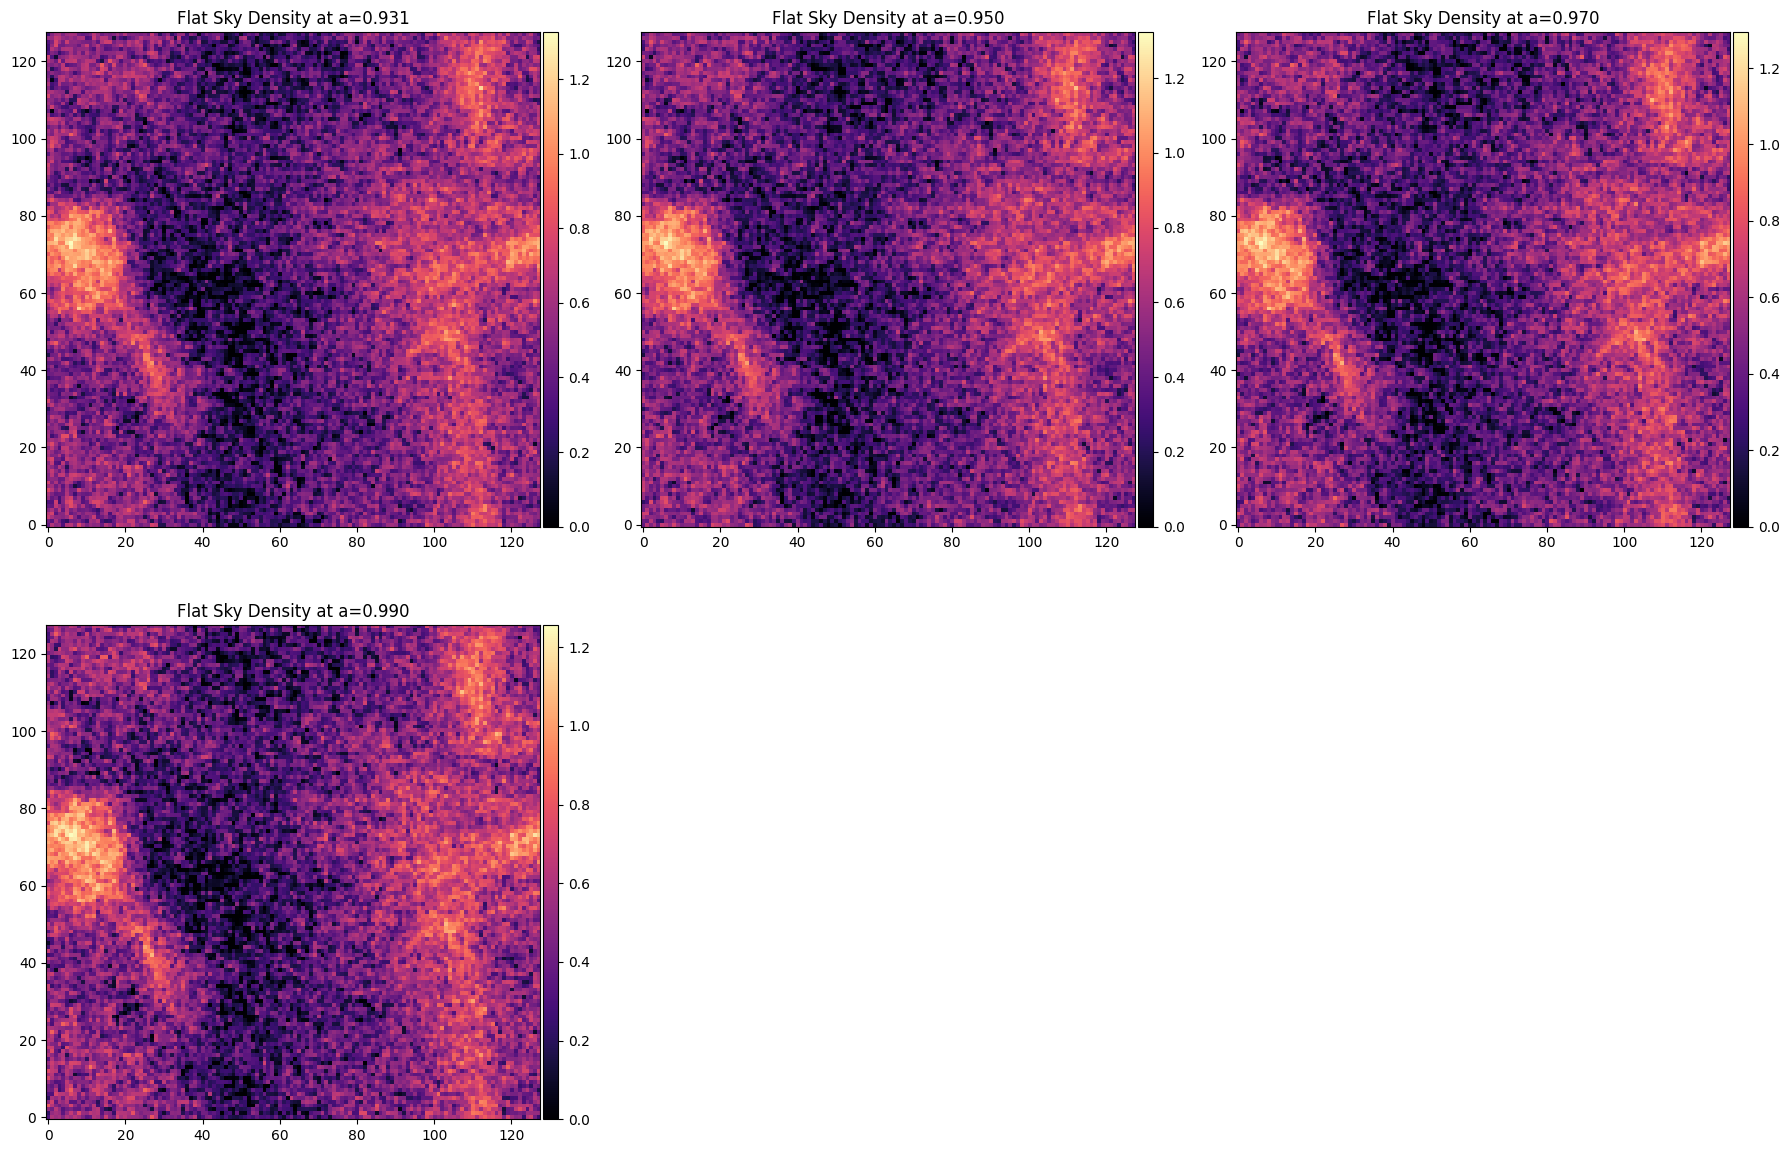

In [52]:
final_dx_dkk.paint().project().show(apply_log=True)

In [53]:
(jpm_particles.array - final_dx_dkk.array).max()

Array(233.12902518, dtype=float64)

## 7. ReversibleDoubleKickDrift (KKD) with Checkpointed Adjoint

Run the `ReversibleDoubleKickDrift` solver with checkpointed adjoint. This solver stores states for exact backward stepping.

In [ ]:
# Create KKD solver
solver_kkd = ReversibleDoubleKickDrift(
    pgd_kernel=NoCorrection(),
    interp_kernel=NoInterp(painting=PaintingOptions(target="particles")),
)

def run_kkd_checkpointed(initial_conditions, cosmo, t0, t1, dt0):
    """Run KKD solver with checkpointed adjoint."""
    # Get LPT initial conditions
    dx, p, _ = lpt(
        cosmo, initial_conditions, particles=None, a=t0, order=1,
        sharding=None, halo_size=0
    )
    
    # Convert to ParticleFields
    displacement, velocities = make_particle_fields(dx, p)
    
    snapshots = integrate(
        y0=(displacement, velocities),
        cosmo=cosmo,
        ts=jnp.array([t1]),
        solver=solver_kkd,
        t0=t0, t1=t1, dt0=dt0,
        adjoint='checkpointed'
    )
    return snapshots.array[0]  # Final displacement array

# Test forward pass
print("Running KKD (checkpointed) forward pass...")
final_dx_kkd_cp = run_kkd_checkpointed(initial_conditions, cosmo, t0, t1, dt0)
print(f"Final displacement norm: {jnp.linalg.norm(final_dx_kkd_cp):.6f}")

# Test gradient
def loss_kkd_cp(ic):
    dx_final = run_kkd_checkpointed(ic, cosmo, t0, t1, dt0)
    return jnp.sum(dx_final**2)

print("Computing KKD (checkpointed) gradient...")
grad_kkd_checkpoint = jax.grad(loss_kkd_cp)(initial_conditions)
print(f"Gradient norm: {jnp.linalg.norm(grad_kkd_checkpoint):.6f}")

## 8. ReversibleDoubleKickDrift (KKD) with Reverse Adjoint

Run the `ReversibleDoubleKickDrift` solver with custom reverse adjoint. This uses explicit backward stepping through `solver.reverse()` for gradient computation.

In [ ]:
def run_kkd_reverse(initial_conditions, cosmo, t0, t1, dt0):
    """Run KKD solver with reverse adjoint."""
    # Get LPT initial conditions
    dx, p, _ = lpt(
        cosmo, initial_conditions, particles=None, a=t0, order=1,
        sharding=None, halo_size=0
    )
    
    # Convert to ParticleFields
    displacement, velocities = make_particle_fields(dx, p)
    
    snapshots = integrate(
        y0=(displacement, velocities),
        cosmo=cosmo,
        ts=jnp.array([t1]),
        solver=solver_kkd,
        t0=t0, t1=t1, dt0=dt0,
        adjoint='reverse'
    )
    return snapshots.array[0]  # Final displacement array

# Test forward pass
print("Running KKD (reverse) forward pass...")
final_dx_kkd_rev = run_kkd_reverse(initial_conditions, cosmo, t0, t1, dt0)
print(f"Final displacement norm: {jnp.linalg.norm(final_dx_kkd_rev):.6f}")

# Test gradient
def loss_kkd_rev(ic):
    dx_final = run_kkd_reverse(ic, cosmo, t0, t1, dt0)
    return jnp.sum(dx_final**2)

print("Computing KKD (reverse) gradient...")
grad_kkd_reverse = jax.grad(loss_kkd_rev)(initial_conditions)
print(f"Gradient norm: {jnp.linalg.norm(grad_kkd_reverse):.6f}")

## 9. Legacy ReversibleBaseSolver with Custom Reverse Adjoint

Run the legacy `ReversibleBaseSolver` from `fwd_model_tools.pm.legacy` with the unified `integrate()` function. This solver was the original diffrax-based implementation and is now available as an optional dependency.

In [ ]:
# Create legacy solver
legacy_solver = ReversibleBaseSolver()

def run_legacy_reverse(initial_conditions, cosmo, t0, t1, dt0):
    """Run legacy ReversibleBaseSolver with custom reverse adjoint."""
    # Get LPT initial conditions
    dx, p = lpt(
        cosmo, initial_conditions, scale_factor_spec=t0, order=1,
        painting=PaintingOptions(target="particles")
    )
    
    # Get symplectic operators from legacy module
    drift_op, kick_op, first_kick_op = symplectic_fpm(cosmo, dx, dt0, use_growth=False)
    
    # Create ODE terms (kick first, then drift for this solver)
    ode_terms = (ODETerm(kick_op), ODETerm(drift_op))
    
    # Apply first kick before integration (FastPM initialization)
    dp_first = first_kick_op(t0, dx, cosmo)
    p_kicked = ParticleField.FromDensityMetadata(
        array=p.array + dp_first.array,
        field=p,
        scale_factors=t0,
    )
    
    # Initial state: (velocity, position) for ReversibleBaseSolver
    y0 = (p_kicked, dx)
    
    # Use the unified integrate with reverse adjoint (default)
    snapshots = legacy_integrate(
        ode_terms,
        legacy_solver,
        t0=t0, t1=t1, dt0=dt0,
        y0=y0,
        args=cosmo,
        saveat=SaveAt(t1=True),
        adjoint="reverse",  # Use custom reverse-mode VJP
    )
    
    # snapshots is (vel_snapshots, pos_snapshots), return final position
    return snapshots[1].array

# Test forward pass
print("Running Legacy ReversibleBaseSolver forward pass...")
final_dx_legacy = run_legacy_reverse(initial_field, cosmo, t0, t1, dt0)
print(f"Final displacement norm: {jnp.linalg.norm(final_dx_legacy):.6f}")

# Test gradient
def loss_legacy(ic):
    dx_final = run_legacy_reverse(ic, cosmo, t0, t1, dt0)
    return jnp.sum(dx_final**2)

print("Computing Legacy gradient...")
grad_legacy = jax.grad(loss_legacy)(initial_field)
print(f"Gradient norm: {jnp.linalg.norm(grad_legacy):.6f}")

## 10. Results Comparison

Compare gradient norms and correlations across all solver configurations.

In [ ]:
# Collect results
results = {
    'JAXPM diffrax checkpoint': grad_jaxpm,
    'DKK checkpoint': grad_dkk,
    'KKD checkpoint': grad_kkd_checkpoint,
    'KKD reverse': grad_kkd_reverse,
    'Legacy reverse': grad_legacy,
}

print("=" * 60)
print("GRADIENT NORMS")
print("=" * 60)
for name, grad in results.items():
    print(f"{name:30s}: {jnp.linalg.norm(grad):.6f}")

print("\n" + "=" * 60)
print("FORWARD PASS CONSISTENCY")
print("=" * 60)
final_states = {
    'JAXPM': final_dx_jaxpm,
    'DKK': final_dx_dkk,
    'KKD checkpoint': final_dx_kkd_cp,
    'KKD reverse': final_dx_kkd_rev,
    'Legacy': final_dx_legacy,
}
for name, state in final_states.items():
    print(f"{name:20s}: norm = {jnp.linalg.norm(state):.6f}")

In [ ]:
def compute_correlation(g1, g2):
    """Compute Pearson correlation coefficient between two gradient arrays."""
    g1_flat = g1.flatten()
    g2_flat = g2.flatten()
    return jnp.corrcoef(g1_flat, g2_flat)[0, 1]

print("=" * 60)
print("PAIRWISE GRADIENT CORRELATIONS")
print("=" * 60)

names = list(results.keys())
grads = list(results.values())

for i in range(len(names)):
    for j in range(i + 1, len(names)):
        corr = compute_correlation(grads[i], grads[j])
        print(f"{names[i]:30s} vs {names[j]:30s}: {corr:.6f}")

## 11. Gradient Visualization

Visualize the gradient fields to compare their spatial structure.

In [ ]:
# Plot central slice of gradient fields
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

slice_idx = mesh_size[2] // 2

# Only plot the first 5 (we have 5 results now)
for ax, (name, grad) in zip(axes[:5], results.items()):
    grad_slice = grad[:, :, slice_idx]
    im = ax.imshow(grad_slice, cmap='RdBu_r', origin='lower')
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax, label='Gradient')

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('Central Slice of Gradient Fields', y=1.02)
plt.show()

In [ ]:
# Plot gradient differences relative to JAXPM reference
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

reference = grad_jaxpm
ref_name = 'JAXPM diffrax checkpoint'

comparisons = [
    ('DKK checkpoint', grad_dkk),
    ('KKD checkpoint', grad_kkd_checkpoint),
    ('KKD reverse', grad_kkd_reverse),
    ('Legacy reverse', grad_legacy),
]

for ax, (name, grad) in zip(axes, comparisons):
    diff = grad - reference
    diff_slice = diff[:, :, slice_idx]
    vmax = jnp.max(jnp.abs(diff_slice))
    im = ax.imshow(diff_slice, cmap='RdBu_r', origin='lower', vmin=-vmax, vmax=vmax)
    ax.set_title(f'{name} - {ref_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.colorbar(im, ax=ax, label='Gradient Difference')

plt.tight_layout()
plt.suptitle('Gradient Differences (Central Slice)', y=1.02)
plt.show()

## 12. KKD Adjoint Consistency Check

Verify that `checkpointed` and `reverse` adjoint modes produce identical gradients for the KKD solver.

In [ ]:
# Check KKD checkpoint vs reverse consistency
kkd_diff = grad_kkd_checkpoint - grad_kkd_reverse
kkd_max_diff = jnp.max(jnp.abs(kkd_diff))
kkd_rel_diff = jnp.linalg.norm(kkd_diff) / jnp.linalg.norm(grad_kkd_checkpoint)

print("=" * 60)
print("KKD ADJOINT CONSISTENCY (checkpoint vs reverse)")
print("=" * 60)
print(f"Max absolute difference: {kkd_max_diff:.2e}")
print(f"Relative norm difference: {kkd_rel_diff:.2e}")
print(f"Correlation: {compute_correlation(grad_kkd_checkpoint, grad_kkd_reverse):.10f}")

if kkd_rel_diff < 1e-5:
    print("\nKKD adjoint modes are consistent!")
else:
    print("\nWarning: KKD adjoint modes show significant differences.")

## 13. Summary

Key observations:

1. **Forward consistency**: All methods should produce similar (but not identical due to different integration schemes) final states.

2. **Gradient consistency**: 
   - KKD checkpoint vs KKD reverse should give identical gradients (they use the same forward pass, different backward strategies).
   - DKK and KKD use different stepping schemes (Drift-Kick-Kick vs Kick-Kick-Drift) so their gradients may differ slightly.
   - Legacy ReversibleBaseSolver uses the original diffrax-based implementation with custom reverse-mode VJP.

3. **Solver differences**:
   - `EfficientDriftDoubleKick` (FastPM scheme): Efficient but not reversible.
   - `ReversibleDoubleKickDrift`: Stores state for exact backward stepping, enabling custom VJP with explicit backward pass.
   - `ReversibleBaseSolver` (legacy): Original diffrax-based symplectic solver, now in `fwd_model_tools.pm.legacy`.

4. **Legacy module**:
   - The legacy integrator is now an optional dependency: `pip install fwd-model-tools[legacy]`
   - Uses `symplectic_fpm()` for drift/kick operators and `ReversibleBaseSolver` for integration.
   - Supports both `adjoint="reverse"` (custom VJP) and diffrax AbstractAdjoint objects.